## Spotify artist prediction model

First I will import the libraries that will help us with multiple functions and methods. Per library I will describe where it is needed for.

In [1]:
import pandas as pd #This contains tools to do mathematics and creates the dataframe.
import datetime #This helps working with dates as date objects.
import calendar #We will need this to detect what day in the week it is.

from sklearn.model_selection import train_test_split #To split up the dataset to a train- and testset.
from sklearn.metrics import confusion_matrix #This wil be used to evaluate the quality of the output and will help seeing how accurate the model is.
import matplotlib.pyplot as plt #For visualizing the data, several plots are available in this library.
import seaborn as sns #This helps plotting the data in a graphic.

### Received data from Spotify

To have some more insights on what I have received from Spotify I will have to explore a bit of what the data is telling.

In [2]:
df = pd.read_csv('MyData/PlayedSongs2019.csv', encoding = 'unicode_escape') #Loads in the CSV and the way it's encoded
df.columns = [x.lower() for x in df.columns] #All lowercase for ease of use
count = (len(df))
minutesplayed = df['msplayed'] / (60000)
print ('The dataset contains',count,'plays, which is good for a total of', minutesplayed.sum(), 'minutes.')
df.sample(5) #A sample shows a random pick from the dataset

The dataset contains 31361 plays, which is good for a total of 82676.45748333333 minutes.


endtime      artistname                  trackname  msplayed
12996   5/8/19 14:38        Bartofso         Mbila (feat. Jozo)     99521
3543    2/4/19 19:17  Lucky Fonz III                    Jongens    104865
9138    4/4/19 21:21       Guillermo  Toppertje! - Original Mix    176586
760     1/7/19 23:28           Kempi                     PumPum     81482
21934  8/18/19 10:06          Ronald          Geil Moet Ze Zijn    183663

In this dataset **every play of a song** in 2019 (until 12/12/2019) is saved. It contains **31361 plays.** It shows information about when the song has ended, the track artist/name and for how long it has been played. The reveived data from Spotify contains 4 columns, but we can convert this into more columns, because a date and a time says a lot more. First, we split the time from the date and we convert the mili seconds to minutes played.

### Data cleaning and feature engineering

I will exclude listening to podcasts. When a 'song' is played longer than 14 minutes, there will appear a NaN (not a number). The row will not disappear but in the column of msplayed will appear a NaN. If a 0 would be used, it would give a distorted result and if it would left empty the code would break. 

In [3]:
def podcast_plays(x):
    if(x > 853168): 
        return float('NaN')
    else: 
        return x
df['msplayed'] = df['msplayed'].apply(podcast_plays)

In [4]:
#Time in minutes
df['mnplayed'] = df['msplayed'] / 60000 #Miliseconds are divided by 60 000 to result in minutes

#Date seperated and in compatible format
df['date'] = df['endtime'].str.split(' ').str[0] #This splits up the string where he finds a space. By setting [0] it has been told to pick the first part, which is the just the date.
df['date'] = pd.to_datetime(df['date']) #This converts the date to a format the function is familiar with.

#Just the month
df['month'] = df['date'].dt.month #With this 'dt.' Series, it detects the month from the day and the year. January will stay month 1 and not 0.

#Just the day
df['day'] = df['date'].dt.day #This works the same for the day

#Time seperated
df['time'] = df['endtime'].str.split(' ').str[1] 

#Just the hour
df['hour'] = df['time'].str.split(':').str[0]
df['hour'] = df['hour'].astype('int') #Because there were colons in, it was still a string. 'astype' converts it to an int to do math with later on.

#Just the minute
df['minute'] = df['time'].str.split(':').str[1]
df['minute'] = df['minute'].astype('int')

#These three columns have all been exploited and can now be dropped. It might be needed to run from the beginning because the columns now have been dropped.
del df['endtime']
del df['time']
del df['msplayed'] 

df.sample(8) #Let's see if the division has succeeded.

artistname                       trackname  mnplayed  \
1091                    The Scene       Iedereen Is Van De Wereld  0.149250   
12373  The Black & White Brothers  Put Your Hands Up - Vocal Edit  0.685017   
404                   Yves Larock                         Rise Up  1.611333   
31253   De Jeugd Van Tegenwoordig                   T Gaat Te Fur  6.496000   
24911               Tony Esposito                      Papa Chico  4.015550   
21614                   Fiberroot  Roccodrillo - Shall Ocin Remix  4.804417   
21133                 Andre Hazes               Ik Ben Een Gokker  3.182667   
4207               Circus Custers                          Monica  3.696667   

            date  month  day  hour  minute  
1091  2019-01-11      1   11    14      16  
12373 2019-04-29      4   29    16      18  
404   2019-01-05      1    5    23      43  
31253 2019-12-10     12   10    15      26  
24911 2019-09-16      9   16    21      26  
21614 2019-08-16      8   16    14      58  
21133 2019-08-13      8   13    12      43  
4207  2019-02-10      2   10    14      25

In [5]:
df['dayofweek'] = df['date'].dt.dayofweek #Converts the date in name of day of week. Monday = 0
df.sample(5)

artistname             trackname  mnplayed       date  month  \
12457  Brandon Fiechter       Amazon Warriors  0.064233 2019-04-30      4   
17125     Jordin Sparks           Battlefield  0.013900 2019-07-05      7   
3876         Brainpower              Dans Ska  0.296550 2019-02-07      2   
5350         Gucci Mane    Both (feat. Drake)  0.923117 2019-02-22      2   
14511    Britney Spears  I Love Rock 'N' Roll  0.017500 2019-05-30      5   

       day  hour  minute  dayofweek  
12457   30    12      18          1  
17125    5    21      15          4  
3876     7    18      40          3  
5350    22    12      43          4  
14511   30    17      40          3

To have more insights on what a month says, the seasons of the year are being added. This also brings more information to predict listening behavior. It also tells that month 12 is next to month 1 and is next to each other and not 11 months from eachother. The same works with the period in the day.

In [6]:
#Season
df['spring'] = (df['month'] > 2) & (df['month'] < 6)
df['summer'] = (df['month'] > 5) & (df['month'] < 9)
df['fall'] = (df['month'] > 8) & (df['month'] < 12)
df['winter'] = (df['month'] < 3) | (df['month'] == 12)

#Period
df['morning'] = (df['hour'] > 4) & (df['hour'] < 13)
df['afternoon'] = (df['hour'] > 11) & (df['hour'] < 18)
df['evening'] = (df['hour'] > 16) & (df['hour'] < 22)
df['night'] = (df['hour'] > 16) | (df['hour'] < 22)

#Weekend or not
df['is_weekend'] = (df['dayofweek'] == 5) | (df['dayofweek'] == 6)
df.sample(5)

artistname                                trackname  mnplayed  \
16591    Simon & Garfunkel  The Sound of Silence - Acoustic Version  3.090217   
14821         Loyle Carner                                Damselfly  2.877550   
856                N.E.R.D                                    Lemon  0.043000   
10864  The Black Eyed Peas                                  Imma Be  1.423183   
27675        Thomas Helmig                               Stupid Man  0.000000   

            date  month  day  hour  minute  dayofweek  spring  summer   fall  \
16591 2019-07-03      7    3    23       6          2   False    True  False   
14821 2019-06-07      6    7     3      47          4   False    True  False   
856   2019-01-08      1    8    11       8          1   False   False  False   
10864 2019-04-16      4   16    16      15          1    True   False  False   
27675 2019-10-23     10   23     9      42          2   False   False   True   

       winter  morning  afternoon  evening  night  is_weekend  
16591   False    False      False    False   True       False  
14821   False    False      False    False   True       False  
856      True     True      False    False   True       False  
10864   False    False       True    False   True       False  
27675   False     True      False    False   True       False

In [7]:
#This shows a number of how many times the song and the artist occurs in the complete set. The artistcount will not be used in the prediction, that gives away to much.
df['artistcount'] = df.groupby(['artistname'])['artistname'].transform('count') #Shows how many this specific artist appeared throughout the year
df['trackcount'] = df.groupby(['trackname'])['artistname'].transform('count') #Shows songs year count (this song by this artist). This avoids having songs with the same name but from a different artist.
df.sample(5)

artistname  \
22323                    Spanker   
31206                   Stef Bos   
12728                  Vengaboys   
23765         Arthit Jim Juntasa   
25452  De Jeugd Van Tegenwoordig   

                                               trackname  mnplayed       date  \
22323                                           Getallen  3.919700 2019-08-23   
31206                                               Papa  0.011217 2019-12-10   
12728                            We_re Going to Ibiza!  0.038733 2019-05-03   
23765  _î_____î__Ü_µ_____ ______µ___...  5.602750 2019-09-08   
25452                     Beter Dan Het Beste Album Ooit  2.912433 2019-09-23   

       month  day  hour  minute  dayofweek  spring  summer   fall  winter  \
22323      8   23    14      45          4   False    True  False   False   
31206     12   10    12       4          1   False   False  False    True   
12728      5    3    20      40          4    True   False  False   False   
23765      9    8    21      17          6   False   False   True   False   
25452      9   23    12      25          0   False   False   True   False   

       morning  afternoon  evening  night  is_weekend  artistcount  trackcount  
22323    False       True    False   True       False            6           6  
31206     True       True    False   True       False           24          17  
12728    False      False     True   True       False           43          13  
23765    False      False     True   True        True           26           4  
25452     True       True    False   True       False          744          14

### Insights and findings

To have some more insights in trends and listening behavior, I will visualize some data that I find interesting and see what trends can be found.

#### Most played artists

In [8]:
topartists = df['artistname'].value_counts()
topartists.head(12)

De Jeugd Van Tegenwoordig    744
Eminem                       707
Andre Hazes                  661
Mula B                       359
LouiVos                      346
Bartofso                     279
Marco Borsato                278
Jack Johnson                 266
Jiggy Dje                    262
Acda en de Munnik            252
The Opposites                228
Drake                        226
Name: artistname, dtype: int64

In [9]:
artistcontribution = (100) / (31362/4608)
artistcontribution

14.692940501243545

This 12 artist contribute to the total of plays with **14.7%**, which I expected to be a higher number. This is probably due to listening to playlist with various artist.

#### Division per month

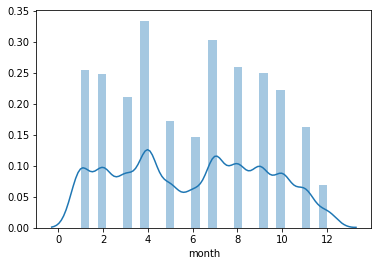

In [10]:
sns.distplot(df['month'])

This shows the plays per month. Because the record went until 12/12/2019, December does not have that much plays. **April** and **July** were months with a lot of plays.

#### Listening behavior on a day

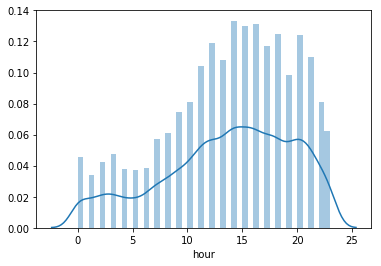

In [11]:
sns.distplot(df['hour'])

You can see that I listen the most to music in the day and in the evening. It becomes less in the night and the morning.

#### Locating the plays

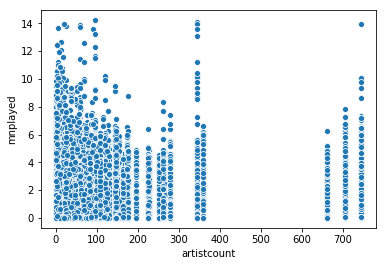

In [12]:
sns.scatterplot(x='artistcount', y='mnplayed', data=df)

In this scatterplot you can see that I listen the most to artists with a low artist count. This means the most plays come from various artists.

In [13]:
artistmean = df['artistcount'].mean()
artistmedian = df['artistcount'].median()
print('The average of listening to one specific artist is', artistmean, ' times. But the outliers play a big role here. A number that says more about the density and is arranged in order of magnitude, is the median:',artistmedian)

The average of listening to one specific artist is 106.26743407416855  times. But the outliers play a big role here. A number that says more about the density and is arranged in order of magnitude, is the median: 32.0


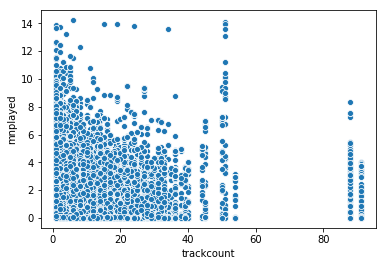

In [14]:
sns.scatterplot(x='trackcount', y='mnplayed', data=df)

In [15]:
trackmean = df['trackcount'].mean()
trackmedian = df['trackcount'].median()
print('The average of listening to one specific artist is', trackmean, ' times. But the outliers play a role here. A number that says more about the density and is arranged in order of magnitude, is the median:',trackmedian)

The average of listening to one specific artist is 9.489525206466631  times. But the outliers play a role here. A number that says more about the density and is arranged in order of magnitude, is the median: 7.0


### Selection of artists to predict

In [16]:
df_sub = df[(df['artistname'] == 'De Jeugd Van Tegenwoordig') | (df['artistname'] == 'Eminem') | (df['artistname'] == 'Andre Hazes') | (df['artistname'] == 'Mula B')
             | (df['artistname'] == 'Jack Johnson') | (df['artistname'] == 'Jiggy Dje') | (df['artistname'] == 'Drake')]
count1 = (len(df_sub))
df_sub.sample(5)

artistname        trackname  mnplayed       date  month  day  hour  \
23084  Jack Johnson  Banana Pancakes  2.739783 2019-09-02      9    2    16   
17903        Mula B   Meesterplusser  0.346017 2019-07-12      7   12     3   
18815  Jack Johnson     No Other Way  3.159767 2019-07-21      7   21    18   
31051   Andre Hazes    'T Rode Licht  3.571333 2019-12-07     12    7    15   
26276        Eminem             Baby  0.222667 2019-10-05     10    5    18   

       minute  dayofweek  spring  summer   fall  winter  morning  afternoon  \
23084      40          0   False   False   True   False    False       True   
17903      40          4   False    True  False   False    False      False   
18815      39          6   False    True  False   False    False      False   
31051      55          5   False   False  False    True    False       True   
26276      48          5   False   False   True   False    False      False   

       evening  night  is_weekend  artistcount  trackcount  
23084    False   True       False          266           9  
17903    False   True       False          359           4  
18815     True   True        True          266           3  
31051    False   True        True          661           6  
26276     True   True        True          707           8

In [17]:
print ('I have chosen to pick these 5 artists because their music style is not very alike. This makes a stronger distinction between the artist and with this less confusion. The subset consists of', count1, 'plays')

I have chosen to pick these 5 artists because their music style is not very alike. This makes a stronger distinction between the artist and with this less confusion. The subset consists of 3225 plays


In [18]:
artists = df_sub['artistname'] #In order to just receive the artist seperated from the dataframe. Later these artist will be converted to numbers, so the number can be predicted.
artists.sample(5)

25773    Eminem
9880     Mula B
15285    Eminem
10228    Mula B
17580    Mula B
Name: artistname, dtype: object

In [19]:
from sklearn import preprocessing #This library provides functions to convert 
import numpy as np #This will help converting the artist to numbers
convert = preprocessing.LabelEncoder()
convert.fit(['De Jeugd Van Tegenwoordig', 'Eminem', 'Andre Hazes', 'Mula B', 'Jack Johnson', 'Jiggy Dje', 'Drake'])
convert.transform(artists)
numbers = convert.transform(artists)
np.nan_to_num(numbers)
numbers

array([5, 2, 4, ..., 0, 6, 6])

#### Dictionary
* 0 = De Jeugd van Tegenwoordig
* 1 = Eminem
* 2 = Andre Hazes
* 3 = Mula B
* 4 = Jack Johnson
* 5 = Jiggy Dje
* 6 = Drake

### Predicting the played artist with the given data

I have created several X variables and this will help me to predict the artist. A KNN classifier will run through the dataset and predict the artist, because the artist is already known, it can check whether it is predicted correct. This accuracy will end up in a score. I have decided to not take the minute when a song is played within the X matrix, because this is not telling something which helps predicting the artist. Also, the score improved after deleting the minute. 

Next to this, I will split the dataset in 2 parts. One set will be the train set (70%) and the other part will be the test set (30%). We do this to make sure the model works for as well the train set as the test set.

In [20]:
X = df_sub[['month', 'hour', 'day', 'mnplayed', 'dayofweek', 'is_weekend', 'winter', 'spring', 'summer', 'fall']] #The X matrix that will help to predict the artist
y = numbers #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [21]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=4) #It will look at 4 'neighbors', the unkown value will become what resulted in the major vote of these 4.               
knn = knn.fit(X_train, y_train) #This fits the k-nearest neighbor model with the train data
score = knn.score(X_test, y_test) #This calculates in what extend it fits on the test data
score

0.7324380165289256

#### Predicting an artist with simulative data

In [22]:
df_predict = pd.read_csv('MyData/prediction.csv', encoding = 'unicode_escape')
df_predict.head(5)

month  hour  day  mnplayed  dayofweek  is_weekend  winter  spring  summer  \
0      3    19   10  4.372934          2        True   False    True   False   

    fall  
0  False

In [23]:
X_train.sample(5)

month  hour  day  mnplayed  dayofweek  is_weekend  winter  spring  \
16288      7     3    1  3.565333          0       False   False   False   
13945      5    16   20  1.486433          0       False   False    True   
26903     10    16   11  0.024417          4       False   False   False   
24891      9    17   16  0.992567          0       False   False   False   
23438      9    20    5  3.261333          3       False   False   False   

       summer   fall  
16288    True  False  
13945   False  False  
26903   False   True  
24891   False   True  
23438   False   True

### Prediction for this new data

In [24]:
y_test_pred = knn.predict(df_predict) #This will predict the number listening to the knn model.
y_test_pred

array([0])

In [25]:
y_test_pred_proba = knn.predict_proba(df_predict)  
y_test_pred_proba

array([[0.75, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ]])

75% of the results lead to [0], De Jeugd Van Tegenwoordig.

In [26]:
y_test_pred = knn.predict(X_test) #The predicted values
cm = confusion_matrix(y_test, y_test_pred) #This creates the confusion matrix. In a confusion matrix you can see on what values the model was wrong (and confused by) and on what values it was correct.
cm

array([[151,   9,   7,   6,   4,   4,  11],
       [ 19, 194,   5,  14,   2,   4,   9],
       [ 16,   7,  19,   8,   1,   1,  10],
       [  6,   9,   2, 177,   0,   0,   0],
       [  7,   4,   1,   5,  61,   0,   1],
       [  5,   3,   4,  10,   1,  45,   2],
       [ 22,  19,   8,   9,   0,   4,  62]])

In [27]:
conf_matrix = pd.DataFrame(cm, index=['DJVT', 'Eminem', 'Andre Hazes', 'Mula B', 'Jack Johnson', 'Jiggy Dje', 'Drake'], columns = ['DJVT(P)', 'Eminem(P)', 'Andre Hazes(P)', 'Mula B(P)', 'Jack Johnson(P)', 'Jiggy Dje(P)', 'Drake(P)']) 
conf_matrix

DJVT(P)  Eminem(P)  Andre Hazes(P)  Mula B(P)  Jack Johnson(P)  \
DJVT              151          9               7          6                4   
Eminem             19        194               5         14                2   
Andre Hazes        16          7              19          8                1   
Mula B              6          9               2        177                0   
Jack Johnson        7          4               1          5               61   
Jiggy Dje           5          3               4         10                1   
Drake              22         19               8          9                0   

              Jiggy Dje(P)  Drake(P)  
DJVT                     4        11  
Eminem                   4         9  
Andre Hazes              1        10  
Mula B                   0         0  
Jack Johnson             0         1  
Jiggy Dje               45         2  
Drake                    4        62

The model works better for artist with more plays, such as **Eminem**, because it has become smarter about this artist. You can also see that artist that are a bit alike (Eminem and Drake), it predicted it to be Drake 19 times when it was Eminem but only 4 times that it was Jack Johnson, which is an artist with a whole other style/genre.

In [28]:
eminem_recall = (194) / (194+19+5+14+2+4+9) * 100
eminem_precision = (194) / (194+9+7+9+4+3+19) * 100
print('The prediction for Eminem has a a recall of', eminem_recall, '%, the precision is', eminem_precision, '.')

The prediction for Eminem has a a recall of 78.54251012145748 %, the precision is 79.18367346938776 .


$recall = \frac{194}{194+19+5+14+2+4+9} = 0.785$

$precision = \frac{194}{194+9+7+9+4+3+19} = 0.792$

In [29]:
drake_recall = (62) / (62+2+1+10+9+11) * 100
drake_precision = (62) / (62+4+9+8+19+22) * 100
print('The prediction for Drake has a a recall of', drake_recall, '%, the precision is', drake_precision, '.')

The prediction for Drake has a a recall of 65.26315789473685 %, the precision is 50.0 .


$recall = \frac{62}{62+2+1+10+9+11} = 0.653$

$precision = \frac{62}{62+4+9+8+19+22} = 0.5$

As you can see it works worse for artist where it 'became less smart' for, such as **Drake**. But in general, also the recall and precision score for Drake is a fine score and a total accuracy score of **73.2%** is one to be glad with.